### Process_CoreBx_island_v4

Read the interpolated DEMs for the entire island and do volume calcs.
This version was modifed in Santa Cruz to make new figure, and on the return to Woods Hole to process newest DEMs.

This reads the .nc file created by `CoreBx_island_v2` and is based on Process_CoreBx_multi_v2.

It gets a `v4` because calcs have changed. Not sure `v3` has anything of worth.

TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add colorbars. Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
import pickle
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

tcmap=cmap_ncb
#tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')

In [2]:
%run -i CoreBx_funcs

In [3]:
# Dates for DEMs
dates = ([\
         "30 Aug 2019",\
         "13 Sep 2019",\
         "11 Oct 2019",\
         "26 Nov 2019"])

# Offsets for DEM elevation corrections (should not be needed when we get to Andy's data )
# offset = np.array([0., 0., 0., 0.])
offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317])

MHHW = 0.4 #elevation of MHHW per VDATUM

# hole-filling options
holes = (["clip","extend"])
ihole = 1 # pick 1 or 2d

# Make a dict, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 

# This block is copied from CoreBx_multi, with addition of xs_end and d_end:
# Not sure value / settings of xs_end and d_end for entire island
r = {'name':"ncorebx","e0": 378500.,"n0": 3856350.,"xlen": 36000.,"ylen": 1100.,"dxdy": 1.,"theta": 42.,'xs_end':800,'d_end':600}

# initialize maps arrays fo
nmaps = len(dates)
vsum = np.zeros((nmaps))
vsumall = np.zeros((nmaps))
vchange = np.zeros((nmaps-1))
vchangeall = np.zeros((nmaps-1))

statsfn = "island_stats_{}.txt".format(holes[ihole])
sfile = open(statsfn, "w")

print("",file=sfile)
print('Region: ',r['name'],file=sfile)

# read in the multi-map .nc file
fn = r['name']+'.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] + offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-1.0)
map_stats(dsaa,sfile)

# read in the fill map
fnf = r['name']+'_Sep_fill.nc'                
dsf = xr.open_dataset(fnf)
dsfa = np.squeeze(dsf.to_array())
ncrossf,nalongf=np.shape(dsfa)
print('ncrossf, nalongf: ',ncrossf,nalongf)

# correct for August offset
dsfa = dsfa+offset[0]

# NaNs below -1 m
dsfa = dsfa.where(dsfa>=-1.) 
map_stats2d(dsfa,sfile)

nmaps, ncross, nalong:  4 1100 36000
ncrossf, nalongf:  1100 36000


(1.1373216198309324, 1.1977021506782808)

In [4]:
%run -i CoreBx_funcs
# Read in the digitized profile of dune crest profile
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line.csv",header = None)
df
xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values
%run -i CoreBx_funcs

xdune,ydune=UTM2rot(xUTM,yUTM,r)
y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(y)

n      = 36001.000
nnan   = 2557.000
mean   = 245.268
std    = 108.260
min    = 0.000
max    = 584.427
d5     = 65.514
d25    = 182.148
d50    = 250.981
d75    = 310.860
d95    = 421.038


CoreBx_funcs.py:12: RuntimeWarning: invalid value encountered in less
  d5 = np.nanpercentile(x,5.)


Text(0, 0.5, 'Cross-shore distance (m)')

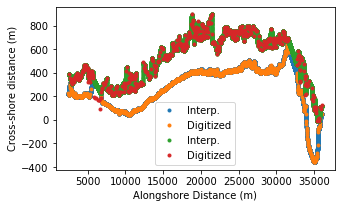

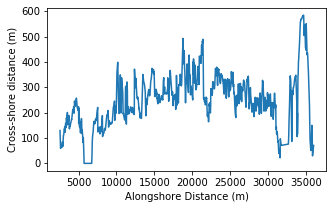

In [5]:
# read in the digitized profile for the back side at the ~1.25-m contour interval
dfb=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\back_125.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values
# rotate to alongshore/cross-shore coordinates
xback,yback=UTM2rot(xUTMb,yUTMb,r)
# interplote
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
ybacki = fb(y)

# ensure back >= dune
ybacki[ybacki<ydunei]=ydunei[ybacki<ydunei]
iswide = ybacki-ydunei

stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(y,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(y,ybacki,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(y,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

0 0.0 225.74025020608678
dx:  1.0
nmaps, length profiles:  4 1100
Shape of dist:  (1100,)
Shape of profs:  (4, 1100)
Shape of pfill:  (1100,)
0 295 [       nan        nan        nan 1.56570669 1.69909426 1.8243568 ]
1 293 [       nan        nan        nan 0.68807215 0.77485748 0.85008706]
2 312 [       nan        nan        nan 1.48088649 1.55591577 1.73048172]
3 282 [       nan        nan        nan 0.71988809 0.57045179 0.46264206]
extend
Slope is: 0.1525
Slope is: 0.0656
Slope is: 0.1308
Slope is: -0.0441
0 295 [0.00915533 0.16168222 0.31420911 0.46673599 0.61926288 0.77178976]
1 293 [0.24807692 0.31364474 0.37921256 0.44478038 0.5103482  0.57591602]
2 312 [0.13496449 0.26581381 0.39666313 0.52751246 0.65836178 0.7892111 ]
3 282 [0.         0.         0.         0.71988809 0.57045179 0.46264206]
iisl, disl 658 953.0
iisl, disl 660 953.0
iisl, disl 641 953.0
iisl, disl 671 953.0
i, zmax, dmax 0 5.1274213859946265 361.0
i, zmax, dmax 1 5.081095084311697 361.0
i, zmax, dmax 2 5.0601840

CoreBx_funcs.py:197: RuntimeWarning: invalid value encountered in greater_equal
  ixd[i] = int(np.argwhere((profs[i,:]>=datum))[0])


Wall time: 1.05 s


<Figure size 432x288 with 0 Axes>

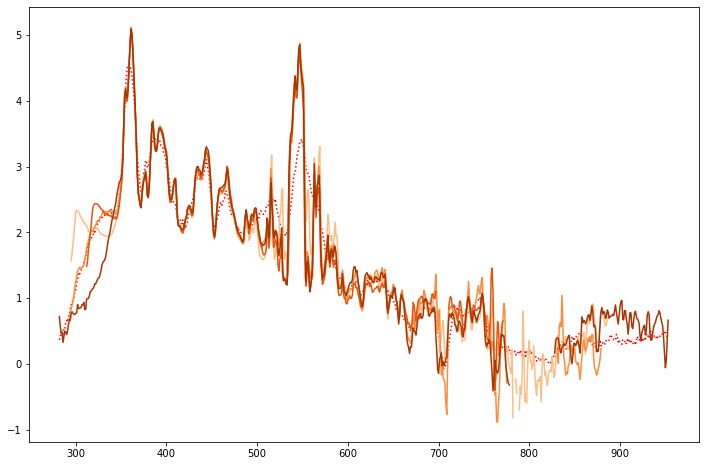

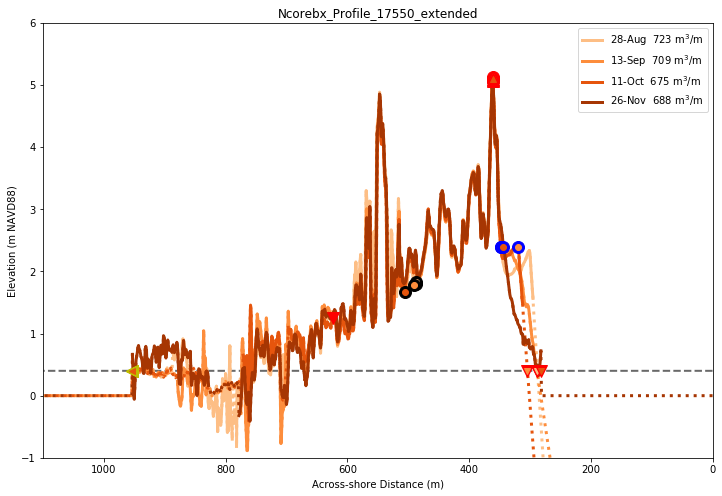

In [6]:
%%time
%run -i CoreBx_funcs

# single profile code

dist = np.arange(0,ncross)
iprof = 17550
#iprof = 35999
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

nprofs = 1

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe = v.copy()
width_island = v.copy()
width_platform = v.copy()

maxdist = 100.
proff = np.squeeze(np.array((dsaa[:,:,iprof])))
pfill = np.squeeze(np.array((dsfa[:,iprof])))

title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
i=0
print(i,y[i],ydune[i])


v[:,i], vp[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe[:,i],\
width_island[:,i], width_platform[:,i] = \
      pvol(dist,proff,pfill,ydunei[iprof],ybacki[iprof],\
      title_str,pnames,imethod='extend',\
      datum=datum,\
      maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
      iverbose=True,iplot=True,iprint=True)

In [7]:
%%time
%run -i CoreBx_funcs
# process all of them
dist = np.arange(0,ncross)
iprof = 6500;
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

profile_list = range(0,nalong,1)
nprofs = len(profile_list)
print(nprofs, profile_list)

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe = v.copy()
width_island = v.copy()
width_platform = v.copy()

maxdist = 100.
for i, iprof in enumerate(profile_list):
    proff = np.squeeze(np.array((dsaa[:,:,iprof])))
    pfill = np.squeeze(np.array((dsfa[:,iprof])))

    title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
    y[i] = iprof
    #print(iprof,y[iprof],ydune[iprof])
    # dunes are farther back in NE portion
    if y[i] >=25000:
        maxdist = 200.
    v[:,i], vp[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe[:,i],\
    width_island[:,i], width_platform[:,i] = \
          pvol(dist,proff,pfill,ydunei[iprof],ybacki[iprof],\
          title_str,pnames,imethod='extend',\
          datum=datum,\
          maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
          iverbose=False,iplot=False,iprint=False)


36000 range(0, 36000)


CoreBx_funcs.py:197: RuntimeWarning: invalid value encountered in greater_equal
  ixd[i] = int(np.argwhere((profs[i,:]>=datum))[0])
CoreBx_funcs.py:426: RuntimeWarning: Mean of empty slice
  cz = np.nanmean(z)
CoreBx_funcs.py:427: RuntimeWarning: invalid value encountered in double_scalars
  cx = np.nansum(z*x)/np.nansum(z)


Wall time: 1min 17s


<Figure size 432x288 with 0 Axes>

In [8]:
# volumme calcs
vp_tot = np.nansum(vp,1)
print(vp_tot)
ap_tot = np.nansum(width_platform,1)
print(ap_tot)
print(vp_tot/vp_tot[0])

[16541906.98529588 13713517.05694707 13452406.8044838  13881856.34299988]
[11224150.85063129 10423134.85063129 10516196.85063129 10431525.85063129]
[1.         0.82901669 0.81323192 0.83919323]


In [27]:
# Uncertainty on volume calcs
import numpy as np
sigma_rs = np.ones_like(vp_tot)*np.nan
sigma_sc = sigma_rs.copy()
sigma_rmsd = np.sqrt(2.*0.2**2)
print('sigma_rmsd:',sigma_rmsd)

L2 = 1. # 1-m grid
for imap in range((nmaps)):

    # Uncorrelated random error
    n = ap_tot[imap] # approximate area
    print('area:',n)
    sigma_rs[imap] = sigma_rmsd/np.sqrt(n)

    # Spatially correlated data (max values)
    sill=np.sqrt(0.03)
    sigma_sill= np.sqrt( sill )
    r = 360.
    sigma_sc[imap] = (sigma_sill/np.sqrt(n)) * np.sqrt((np.pi*r**2)/(5.*L2))
    Asc = np.pi*r**2/(5.*n*L2)
    print('Asc: ',Asc)
    
# Systematic error
sigma_sys = 0.07

# total error
sigma_tot = np.sqrt( sigma_rs**2. + sigma_sc**2. + sigma_sys**2.)

for i in range(nmaps-1):
    ss=stat_summary(width_platform[i,:],iprint=False)
    print('Platform width d50: {:.3f}'.format(ss['d50']))

    print('sigma_rs:           {:.6f}'.format(sigma_rs[i]))
    print('sigma_sc:           {:.6f}'.format(sigma_sc[i]))
    print('sigma_tot:          {:.6f}'.format(sigma_tot[i]))

print('ap_tot: ',ap_tot)
print('vp_tot: ',vp_tot)
print('avg. elevation: ',vp_tot/ap_tot)
vdiff = np.diff(vp_tot,1,0)
print('diff(vp_tot):',vdiff)
print('diff as fraction of initial volume: ',vdiff/ap_tot[0])
err = ap_tot*sigma_tot
print('err volume',err)
print('err pct of volume initial volume: ',err/np.mean(np.diff(vp_tot,1,0)))
print('err (frac of volume change):',err/vp_tot[0])
print('avg. elevation change: ',vdiff/np.mean(ap_tot))

sigma_rmsd: 0.28284271247461906
area: 11224150.850631287
Asc:  0.0072548990711816305
area: 10423134.850631287
Asc:  0.007812436733092399
area: 10516196.850631287
Asc:  0.007743301379543802
area: 10431525.850631287
Asc:  0.007806152498401708
Platform width d50: 339.009
sigma_rs:           0.000084
sigma_sc:           0.035448
sigma_tot:          0.078464
Platform width d50: 322.379
sigma_rs:           0.000088
sigma_sc:           0.036785
sigma_tot:          0.079077
Platform width d50: 321.364
sigma_rs:           0.000087
sigma_sc:           0.036622
sigma_tot:          0.079001
ap_tot:  [11224150.85063129 10423134.85063129 10516196.85063129 10431525.85063129]
vp_tot:  [16541906.98529588 13713517.05694707 13452406.8044838  13881856.34299988]
avg. elevation:  [1.47377804 1.31568067 1.27920835 1.3307599 ]
diff(vp_tot): [-2828389.92834881  -261110.25246327   429449.53851608]
diff as fraction of initial volume:  [-0.25199144 -0.02326325  0.03826121]
err volume [880691.2867656  824229.54136

### Summary in words
* Initial island volume was 11 million m3, initial area was about 16.5 m2, so inital avg. elevation was 1.47 m
* Volume changes were -2.8 million, -0.26 m, +0.43 million m3
* Uncertainties around these are about 5%
* These changes represent fractional changes of -0.25 -0.02  0.04 of the initial volume
* Average elevation change was -0.27 -0.02  0.04 m


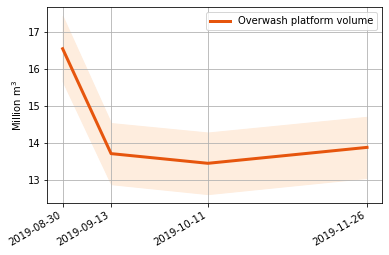

In [11]:
# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
ax.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,vp_tot/1e6,label="Overwash platform volume",c=cols[3],linewidth=3)
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

13
Segments: 18000


Text(0, 0.5, 'Dune toe movement (m)')

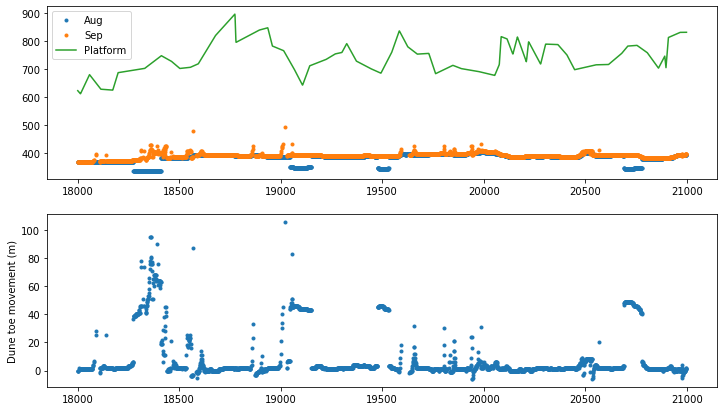

In [28]:
# analyze island segments
sl = 3000
segs = np.arange(0,37000,sl)
sn = 6
ss = segs[sn] 
se = ss+sl
print(len(segs))
print("Segments:",ss)

dtoe_s0 = signal.medfilt(dtoe[0,:], kernel_size=101)
dtoe_s1 = signal.medfilt(dtoe[1,:], kernel_size=101)
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(y[ss:se],dtoe_s0[ss:se],'.',label='Aug')
plt.plot(y[ss:se],dtoe_s1[ss:se],'.',label='Sep')
plt.plot(y[ss:se],ybacki[ss:se],label='Platform')
plt.legend()

ax2=plt.subplot(212)
dtoe_diff = dtoe_s1[ss:se]-dtoe_s0[ss:se]
plt.plot(y[ss:se],dtoe_diff,'.')
plt.ylabel('Dune toe movement (m)')

# for sn, seg in enumerate(segs):
#     ss = seg
#     se = ss+sl
#     plt.figure(figsize=(12,7))
#     ax1=plt.subplot(211)
#     plt.plot(y[ss:se],dtoe_s0[ss:se],'.')
#     plt.plot(y[ss:se],dtoe_s1[ss:se],'.')
#     plt.plot(y[ss:se],dowp[0,ss:se])

#     ax2=plt.subplot(212)
#     dtoe_diff = dtoe_s0[ss:se]-dtoe_s1[ss:se]
#     plt.plot(y[ss:se],dtoe_diff,'.')


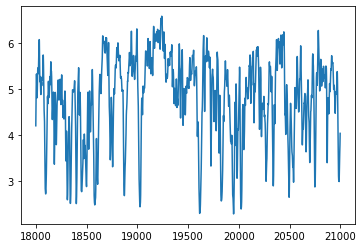

In [29]:
%run -i CoreBx_funcs

if False:
    # smooth first, then difference w/ median filter
    zmax_s0 = signal.medfilt(zmax[0,:], kernel_size=11)
    zmax_s1 = signal.medfilt(zmap0[1,:], kernel_size=11)
    zdiff = zmax_s1-zmax_s0
    zdiff[zdiff>=-0.5]=0.
    
if False:
    # difference first, then smooth
    zmax_0 = zmax[0,:]
    zmax_1 = zmap0[1,:]
    zdiff = zmax_1-zmax_0
    zdiff[zdiff>=-0.5]=0.
    
if True:
    npts = 5
    zmax_s0 = np.convolve(zcrest[0,:], np.ones((npts,))/npts, mode='valid')
    zmax_s1 = np.convolve(zcrest0[1,:], np.ones((npts,))/npts, mode='valid')
    chAug = zmax_s0
#     chAug[chAug>= 0.] = 0.
    chSep = zmax_s1-2.
#     chSep[chSep>= 0.] = 0.

plt.plot(y[ss:se],chAug[ss:se])

In [30]:
%run -i CoreBx_funcs
red3 = ['#fee0d2','#fc9272','#de2d26']
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

# average elevation
melev = vp / width_platform
print(np.shape(melev))
melev_diff = np.diff(melev,1,0)
print(np.shape(melev_diff))
for i in range(nmaps-1):
    ss=stat_summary(melev_diff[i,:],iprint=False)
    print('d50: ',ss['d50'])

(4, 36000)
(3, 36000)
d50:  -0.08987484020186409
d50:  -0.0032823783534694506
d50:  0.013015202620078714


(4, 36000)
250
250
250
250
250
250
(36000,) (36000,)
Mean platform elevation - Sept


Text(0.5, 0, 'Alongshore distance (m)')

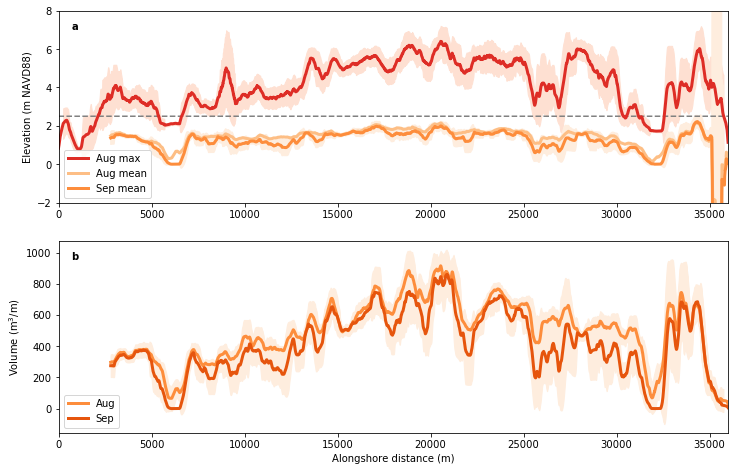

In [31]:
melev0s = running_mean(melev[0,:],501)
melev1s = running_mean(melev[1,:],501)

print(np.shape(melev))
pelev = vp / width_platform
pelev0s = running_mean(pelev[0,:],501)
pelev1s = running_mean(pelev[1,:],501)
pelev1sd = running_stddev(pelev[1,:],501)
pelev_diff = running_mean(pelev[1,:]-pelev[1,:],501)

# average volume
vpmean = np.zeros_like(vp)
vpstd = vpmean.copy()
for i in range(0,4):
    vpmean[i,:] = running_mean(vp[i,:],501)
    vpstd[i,:] = running_stddev(vp[i,:],501)


x = zmax[0,:]
xs = running_mean(x,501)
xstd = running_stddev(x,501)
print(np.shape(x),np.shape(xs))

print("Mean platform elevation - Sept")

plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[1],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[2],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36000))

ax2=plt.subplot(312)
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36000))
plt.xlabel('Alongshore distance (m)')

Text(0.5, 0, 'Alongshore distance (m)')

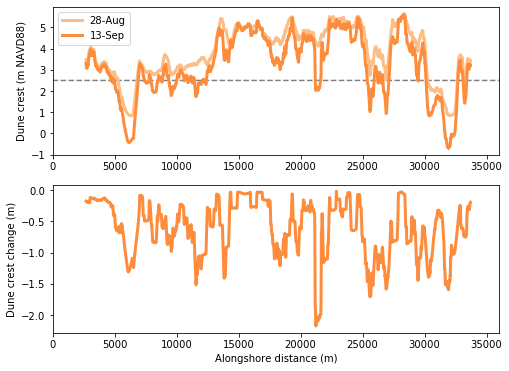

In [32]:
x = zcrest0[0,:]
xs = running_mean(x,501)
x1 = zcrest0[1,:]
x1s = running_mean(x1,501)

plt.figure(figsize=(8,6))
ax2=plt.subplot(211)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=cols[1],label=pnames[0])
plt.plot(y,x1s,'-',linewidth=3,c=cols[2],label=pnames[1])
plt.ylabel('Dune crest (m NAVD88)')
plt.legend()
plt.xlim((0,36000))


xds = running_mean( zcrest0[1,:]-zcrest0[0,:], 501)
ax3=plt.subplot(212)
plt.plot(y,xds,'-',linewidth=3,c=cols[2])
plt.ylabel('Dune crest change (m)')
plt.xlim((0,36000))
plt.xlabel('Alongshore distance (m)')

In [33]:
print((chAug))
nc, channel_area, channel_width, channel_max_depth, channel_avg_depth = analyze_channels(chAug[ss:se])
print('September:')
cw0 = stat_summary(channel_width)
print('Width: N: {} Mean: {} Min: {} Max: {}'.format(cw0['n'],cw0['mean'],cw0['min'],cw0['max']))
ca0 = stat_summary(channel_width)
print('Area:  N: {} Mean: {} Min: {} Max: {}'.format(ca0['n'],ca0['mean'],ca0['min'],ca0['max']))

[nan nan nan ...  0.  0.  0.]


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax1.plot(y,dmax[0,:],'.r')
plt.savefig('dune_crest_testmix.png',bbox_inches='tight', format='png',dpi=200)

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(y[ss:se],dmax[0,ss:se],'.')
#plt.plot(y[ss:se],dmax[0,ss:se],'.')
plt.ylabel('Cross-shore dist. (m)')

ax2=plt.subplot(412)
plt.plot(y[ss:se],zmax_s0[ss:se],'.')
plt.plot(y[ss:se],zmax_s1[ss:se],'.')
plt.ylabel('Crest elev. (m)')

ax3=plt.subplot(413)
plt.plot(y[ss:se],zdiff[ss:se],'-')
plt.ylabel('Elev. Change (m)')

chana = np.cumsum(-zdiff[ss:se])
ax3=plt.subplot(414)
plt.plot(y[ss:se],chana)

In [ ]:
plt.boxplot(channel_width)
plt.ylim( (0,100) )

In [ ]:
%run -i CoreBx_funcs
s = stat_summary(channel_width,iprint=True)

In [ ]:
for sn, seg in enumerate(segs):
    ss = seg
    se = ss+sl
    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')

    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_s0[ss:se],'.')
    plt.plot(y[ss:se],zmax_s1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiff[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiff[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)

    try:
        print('Seg. {} total channel area m^2/m: {:.2f}'.format(sn, chana[-1]/sl) )
    except:
        pass

    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')
    
    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_0[ss:se],'.')
    plt.plot(y[ss:se],zmax_1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiffu[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiffu[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)
    plt.ylabel('Cumulative Area (m^2)')

In [ ]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
print(np.shape(diffmap),file=sfile)
print("Stats for diffmap:",file=sfile)
for i in range(0,nmaps-1):
    print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
    map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
print("\nStats for last minus first:",file=sfile)
map_stats2d(diffmap_tot, sfile)


title_str = '{0:s}'.format(r['name'].capitalize())  

xs_start = 0
xs_end = r['xs_end']
dxdy = r['dxdy']
xs_len = (xs_end-xs_start)
print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

# calculate dhi
dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
print("Shape of dhi: ",np.shape(dhi),file=sfile)

mean_dhi = np.nanmean(dhi,1)
std_dhi = np.nanstd(dhi,1)
print("Mean dhi: ",mean_dhi,file=sfile)
print("Mean and std of dhi: {} {} (m)".format(mean_dhi, std_dhi),file=sfile)
sfile.close()

In [ ]:
# open the log file in append mode
sfile = open(statsfn, "a+")
# calculate centroid of each transect
print('Calculating centroids')

# calculate volumes    
# volumes for each transect in beach and overwash terrace (nmaps, nalong)
v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

# volumes for each transect across entire cell (nmaps, nalong)
vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

# respective volume differences (nmaps-1, nalong)
vdiff = np.squeeze(np.diff(v,axis=0))
vdiffall = np.squeeze(np.diff(vall,axis=0))

print("Shape of v: ",np.shape(v),file=sfile)
print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

# average transect volume for overwash terrace (nmaps)
m = np.mean(v,1)
# average volume change for overwash terrace (nmaps-1)
mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
print("Average transect volume for ow terrace m: ",m,file=sfile)
print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

# update sum over entire island
vsum = vsum+np.nansum(v,1)
vsumall = vsumall+np.nansum(vall,1)
vchange = vchange+np.sum(vdiff,1)
vchangeall = vchangeall+np.sum(vdiffall,1)

island_length = island_length+r['xlen']


# calculate elevations
mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

pc = 100*np.nanmean(vdiff)/np.mean(v)
pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
print("Pct volume change in across entire island m:",pcall,"%",file=sfile)
sfile.close()

In [ ]:
##############################################################################
# Elevation plots
title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

plt.legend(loc='upper right')
ax1.xaxis.set_ticklabels([])
ax1.set_ylim(0,7.5)
plt.ylabel('Dune Crest Elevation (m)')
plt.text(0,.85*7.5,"a) Crest Elevation")
plt.title(title_str)

# Volume plot
ax2=plt.subplot(212)
plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
lb = []
for i in range(0,4):
    lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
ax2.set_ylim(0,950)
plt.xlabel(r'Alongshore Distance (m)')
plt.ylabel(r'Volume (m$^3$/m)')
plt.legend(loc='upper right')
title_str = 'b) Volumes'

plt.text(0,.85*950,title_str)
fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')


In [ ]:
##############################################################################
#  Plot map views
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
# text locations
tx = 0.025*r['xlen']
ty = 0.9*r['ylen']
print("tx, ty:",tx,ty)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

ax[0,0].set_ylabel('Cross-shore Distance (m)')
ax[1,0].set_ylabel('Cross-shore Distance (m)')
ax[2,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_xlabel('Alongshore Distance (m)')

ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

ax[3,1].set_xlabel('Alongshore Distance (m)')

ax[0,0].xaxis.set_ticklabels([])
ax[1,0].xaxis.set_ticklabels([])
ax[2,0].xaxis.set_ticklabels([])
ax[0,1].xaxis.set_ticklabels([])
ax[1,1].xaxis.set_ticklabels([])
ax[2,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[3,1].yaxis.set_ticklabels([])

title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
ax[0,0].set_title(title_str)

fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

# open the log file in append mode
sfile = open(statsfn, "a+")
print('\nOverall statistics for hole filling with {}')
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum[0], file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()

# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(dt,vsumall/1e6,label="Entire island")
plt.plot(dt,vsum/1e6,label="Beach and overwash")
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
plt.title('Island Volume')
fig_name = 'island_volume_{}.svg'.format(holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')